# Lawlingo
Importing stuff

In [131]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import os
import urllib.request
from urllib import parse
import regex as re
import pandas as pd
from joblib import Memory
from datetime import datetime
import textract
from collections import Counter
import matplotlib.pyplot as plt
import csv
memory = Memory('./cache', verbose=0)

In [105]:
BASE_URL = "https://www.domstol.se/"
URL = BASE_URL + "hogsta-domstolen/avgoranden/?f=DecisionType_list:decision"

@memory.cache
def result_urls():
    BANNER_CLASS_NAME = "banner__button"
    MORE_CLASS_NAME = "search-result-item__show-more-btn"
    
    urls = []
    driver = webdriver.Chrome('./chromedriver')
    wait = WebDriverWait(driver, 10)
    driver.get(URL)
    sleep(1.0)
    
    banner_button = driver.find_element_by_class_name(BANNER_CLASS_NAME)
    more_button = driver.find_element_by_class_name(MORE_CLASS_NAME)
    
    wait.until(EC.element_to_be_clickable((By.CLASS_NAME, BANNER_CLASS_NAME)))
    banner_button.click()
        
    while True:
        more_button.click()
        try:
            wait.until(EC.element_to_be_clickable((By.CLASS_NAME, MORE_CLASS_NAME)))
        except:
            break
        
    results = driver.find_elements_by_class_name("u-pr-huge--large")
    urls =  [item.get_attribute("href") for item in results]
    driver.close()
    return urls


@memory.cache
def data(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, "html.parser")

    pdf_element = soup.find("a", href=re.compile(r".+\.pdf"))
    date_element = soup.find("span", class_ = "publisher__byline")
   
    date = datetime.fromisoformat(date_element.text[:-1])
    if pdf_element is not None:
        pdf_url = BASE_URL + pdf_element["href"]
        file_name = re.findall(r"(.+\/)*(.+\..+)$", pdf_url)[0][1]
        urllib.request.urlretrieve(pdf_url, "./cache/temp.pdf")
        text = textract.process('./cache/temp.pdf', encoding='utf-16').decode('utf-16')
        return {"date": date, "url": url, "text": text}
        
    else:
        return None
    
def words(text):
    """
    Returns a list of words from a text.
    """
    text = text.lower()
    text = re.sub('\n', " ", text)
    text = re.sub('[/./?,!/:/(/)_]', "", text)
    words = text.split()
    return words

@memory.cache
def n_matches(word_stem, count_dict):
    """
    Takes a word-count dirct and returns the number of matches given a word stem.
    """
    n = 0
    key = r"^" + word_stem
    for word in count_dict.keys():
        if re.match(key, word):
            n += count_dict[word]
    return n

def n_illegal_ocurrences(illegal_words, count_dict):
    return sum([n_matches(word, count_dict) for word in illegal_words])


In [221]:
import urllib.parse

# This does not work for the urls that contains non-ascii characters. 
@memory.cache
def data_from_csv(filename):
    data = []
    with open(filename, newline='',  encoding='utf-8-sig') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            date = row['Date']
            url = row['Url']
            try:
                urllib.request.urlretrieve(url, "./cache/temp.pdf")
                text = textract.process('./cache/temp.pdf', encoding='utf-16').decode('utf-16')
            except:
                continue
            data.append({'date': datetime.fromisoformat(date), 'url': url, 'text': text})
    return data
   


,url,text,word_dict,n_illegal_occurences,date,migration
2020-04-17 00:00:00,https://www.domstol.se/hogsta-domstolen/avgora...,Sida 1 (11)\n\nHÖGSTA DOMSTOLENS\nDOM\n\nMål n...,"{'sida': 11, '1': 4, '11': 5, 'högsta': 25, 'd...",27.0,NaT,NaN
2020-04-09 00:00:00,https://www.domstol.se/hogsta-domstolen/avgora...,Sida 1 (8)\n\nHÖGSTA DOMSTOLENS\nDOM\n\nMål nr...,"{'sida': 8, '1': 4, '8': 3, 'högsta': 18, 'dom...",21.0,NaT,NaN
2020-04-09 00:00:00,https://www.domstol.se/hogsta-domstolen/avgora...,Sida 1 (7)\n\nHÖGSTA DOMSTOLENS\nBESLUT\n\nMål...,"{'sida': 7, '1': 5, '7': 6, 'högsta': 15, 'dom...",9.0,NaT,NaN
2020-04-08 00:00:00,https://www.domstol.se/hogsta-domstolen/avgora...,Sida 1 (8)\n\nHÖGSTA DOMSTOLENS\nBESLUT\n\nMål...,"{'sida': 9, '1': 9, '8': 5, 'högsta': 14, 'dom...",10.0,NaT,NaN
2020-04-08 00:00:00,https://www.domstol.se/hogsta-domstolen/avgora...,Sida 1 (17)\n\nHÖGSTA DOMSTOLENS\nBESLUT\n\nMå...,"{'sida': 21, '1': 10, '17': 3, 'högsta': 28, '...",21.0,NaT,NaN
...,...,...,...,...,...,...
28,http://kammarrattenistockholm.old.domstol.se/D...,Migrationsöverdomstolen\nAvdelning:\n\nMIG 201...,NaN,NaN,2017-12-22,True
29,http://kammarrattenistockholm.old.domstol.se/D...,Migrationsöverdomstolen\nAvdelning:\n\nMIG 201...,NaN,NaN,2017-12-21,True
30,http://kammarrattenistockholm.old.domstol.se/D...,Migrationsöverdomstolen\nAvdelning:\n\nMIG 201...,NaN,NaN,2017-12-20,True
31,http://kammarrattenistockholm.old.domstol.se/D...,Migrationsöverdomstolen\nAvdelning:\n\nMIG 201...,NaN,NaN,2017-12-18,True


## Downloading and sorting data from decisions.

In [ ]:
with open('./svartlistadeord.txt') as f:
    illegal_words = f.read().splitlines()
    
# Adding decistions from Högsta Domstolen
df = pd.DataFrame([data(url) for url in result_urls() if data(url) is not None])

# Adding decistions from Migrationsdomstolen
df_migration = pd.DataFrame(data_from_csv('./migrations_dommar.csv'))
df_migration["migration"] = True
df.append(df_migration)

df.set_index('date', inplace=True)

# Counting words
df['word_dict'] = list(map(lambda x: Counter(words(x)), df['text']))
df['n_words'] = list(map(lambda x: len(words(x)), df['text']))

# Counting occurences of blacklisted words
df['n_illegal_occurences'] = list(map(lambda x: n_illegal_ocurrences(illegal_words, x), df['word_dict']))

# Calculating the ratio of blacklisted words
df['illegal_ratio'] = df['n_illegal_occurences']/df['n_words']

## Plotting data

In [ ]:
plt.plot(df['illegal_ratio'])
plt.title('Ratio of blacklisted words in each decision')

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


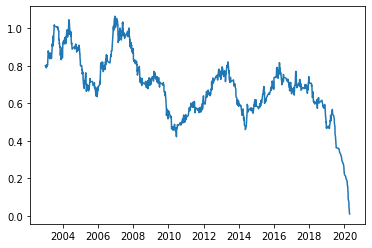

In [29]:
print(type(df.index[0]))
plt.plot(df['illegal_ratio'].rolling('365d', min_periods=1).sum())

In [82]:
df['url'][df['illegal_ratio'].argmax()]
df['url'][df['illegal_ratio'].argmin()]

'https://www.domstol.se/hogsta-domstolen/avgoranden/2019/30430/'